# Import modules and read data

In [1]:
import json
import numpy as np
import pandas as pd
from superlink.superlink import SuperLink
from superlink.simulation import Simulation
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('husl')
%matplotlib inline

In [2]:
# Specify data path
model_input_path = '../data/adaptive_step'
data_input_path = '../data/six_pipes'

# Get model components
superjunctions = pd.read_csv(f'{model_input_path}/superjunctions.csv')
superlinks = pd.read_csv(f'{model_input_path}/superlinks.csv')

# Read input data
Q_in = pd.read_csv(f'{data_input_path}/flow_input.csv', index_col=0)
H_bc = pd.read_csv(f'{data_input_path}/boundary_stage.csv', index_col=0)

# Modify channel geometries

In [3]:
superlinks['shape'] = ['circular', 'rect_closed', 'triangular', 'trapezoidal', 'parabolic', 'elliptical']

In [4]:
superlinks['g1'] = [0.8, 0.5, 1.0, 0.5, 1.0, 0.5]
superlinks['g2'] = [0.0, 0.5, 1.0, 0.5, 1.0, 1.0]
superlinks['g3'] = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]

In [5]:
superlinks

,id,sj_0,sj_1,dx,n,Q_0,ctrl,A_c,C,shape,g1,g2,g3,g4,A_s,h_0,in_offset,out_offset,name
0,0,0,1,300.0,0.014,0,False,0,0,circular,0.8,0.0,0.0,0.0,1.16,0.00001,0.0,0.0,a
1,1,1,2,300.0,0.014,0,False,0,0,rect_closed,0.5,0.5,0.0,0.0,1.16,0.00001,0.0,0.0,b
2,2,2,3,300.0,0.014,0,False,0,0,triangular,1.0,1.0,0.0,0.0,1.16,0.00001,0.0,0.0,c
3,3,1,4,500.0,0.014,0,False,0,0,trapezoidal,0.5,0.5,1.0,0.0,1.16,0.00001,0.0,0.0,d
4,4,4,5,410.0,0.014,0,False,0,0,parabolic,1.0,1.0,0.0,0.0,1.16,0.00001,0.0,0.0,e
5,5,4,2,310.0,0.014,0,False,0,0,elliptical,0.5,1.0,0.0,0.0,1.16,0.00001,0.0,0.0,f


# Instantiate and run model

In [6]:
superlink = SuperLink(superlinks, superjunctions, min_depth=-np.inf, 
                      njunctions_fixed=4, auto_permute=True)    

In [7]:
# Set initial timestep
dt = 60
# Create lists to store error and timestep
errs = []
dts = []

# Create simulation context manager
with Simulation(superlink, Q_in=Q_in, H_bc=H_bc) as simulation:
    # While simulation time has not expired...
    for step in simulation.steps:
        if simulation.t >= simulation.t_end:
            break
        # Step model forward in time
        simulation.step(dt=dt, subdivisions=4, retries=0)
        # Adjust step size
        dt = simulation.compute_step_size(dt)
        # Record internal depth and flow states
        simulation.record_state()
        # Print progress bar
        simulation.print_progress()

[==================================================] 100.0%

# Plot results

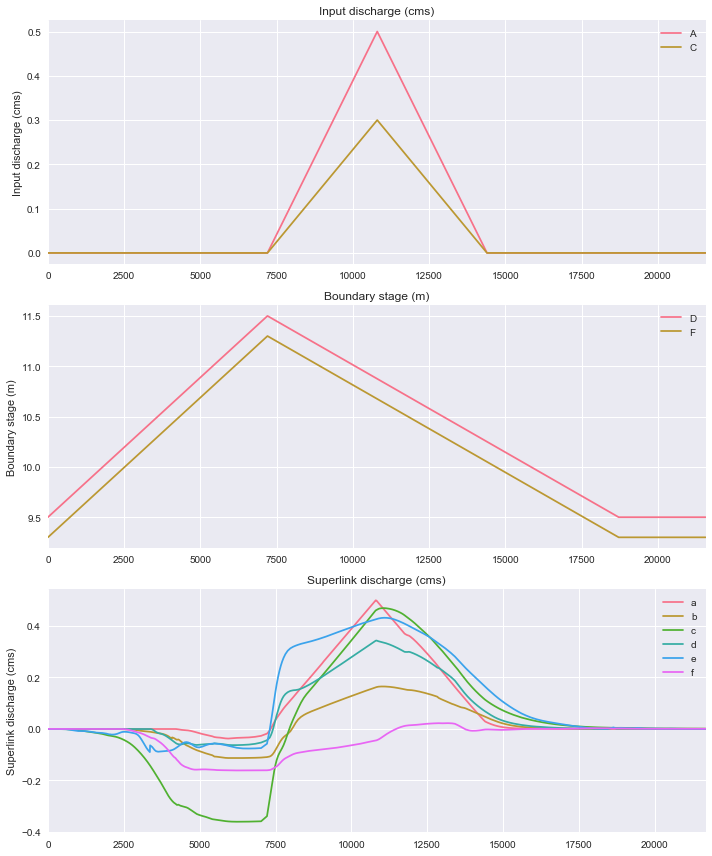

In [8]:
# Plot results
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('husl')
%matplotlib inline

# Instantiate plot
fig, ax = plt.subplots(3, figsize=(10, 12))

# Compute average discharge in superlinks
simulation.states.Q_k = (simulation.states._Q_uk + simulation.states._Q_dk) / 2

# Plot results
simulation.Q_in[['A', 'C']].plot(ax=ax[0], title='Input discharge (cms)')
simulation.H_bc[['D', 'F']].plot(ax=ax[1], title='Boundary stage (m)')
simulation.states.Q_k.plot(ax=ax[2], title='Superlink discharge (cms)')

# Configure plots
ax[0].set_ylabel('Input discharge (cms)')
ax[1].set_ylabel('Boundary stage (m)')
ax[2].set_ylabel('Superlink discharge (cms)')
plt.tight_layout()